In [1]:
%load_ext autoreload
%autoreload 2

import time
from collections import deque, Counter

import numpy as np

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

from dm_control import mjcf
from dm_control import viewer

import torch
import torch.nn as nn
import torch.nn.init as nn_init
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym

from cartpole3d import CartPole3D
from rendering import display_video
from cartpole.modules.policies.state_model_transformer_policy import StateModelTransformerPolicy

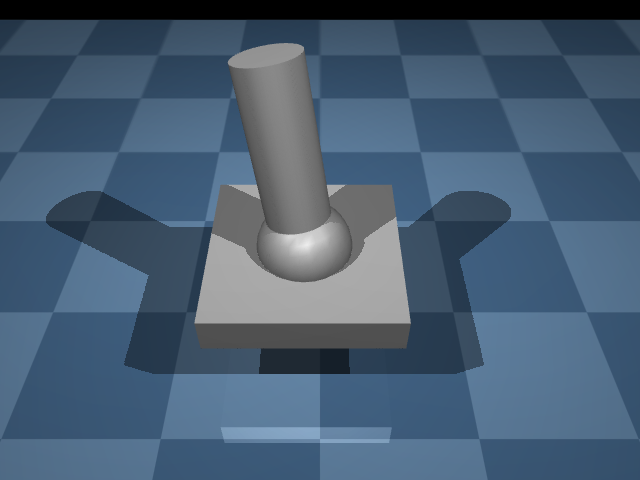

In [3]:
cartpole3d_env = CartPole3D(
    nr_movement_dimensions=2,
    force_magnitude=5000,
    physics_steps_per_step=0.1,
    reset_randomization_magnitude=0.1,
    slide_range=0.5,
    hinge_range=0.8,
    time_limit=3.0,
    step_reward_function=lambda time, action, state: 0, # (time if np.any(np.abs(np.array([1.0, 2.0, 4.0, 6.0, 8.0, 10.0]) - time) < 0.002) else 0) + ((-10) if np.linalg.norm(action) > 0.99 else 0), #-np.linalg.norm(state[:4]) + time / 2,
    out_ouf_range_reward_function=lambda time, action, state: -10 + time * 3,
    time_limit_reward_function=lambda time, action, state: 10000,
)

cartpole3d_env.reset()

for _ in range(200):
    cartpole3d_env.step(np.array([0] * cartpole3d_env.nr_movement_dimensions))

cartpole3d_env.render()

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

eps = 1e-6

seed = time.time_ns() % (2**32)
np.random.seed(seed)
torch.manual_seed(seed)
print(f'seed is {seed}')

def step_reward(time, action, state):
    reward = 0

    reward += time
    
    reward -= 0.1 * np.linalg.norm(state[0:2])
    reward -= np.linalg.norm(state[2:4])
    
    return reward

env = CartPole3D(
    nr_movement_dimensions=2,
    cart_size=0.25,
    force_magnitude=5000,
    physics_steps_per_step=1,
    reset_randomization_magnitude=0.1,
    slide_range=2.5,
    hinge_range=1,
    time_limit=10.0,
    step_reward_function=step_reward, # (time if np.any(np.abs(np.array([1.0, 2.0, 4.0, 6.0, 8.0, 10.0]) - time) < 0.002) else 0) + ((-10) if np.linalg.norm(action) > 0.99 else 0), #-np.linalg.norm(state[:4]) + time / 2,
    out_ouf_range_reward_function=lambda time, action, state: 100 * time**2,# -10 + time * 3,
    time_limit_reward_function=lambda time, action, state: 100,
)
env.reset(seed=seed)

observation_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

gamma = 0.9

action_dist_sd = 0.05

memory_length = 100

minimum_learning_episodes = 20
timestep_discard_limit = 50


def instatiate_policy():
    return StateModelTransformerPolicy(
        in_dim=action_size + observation_size, 
        out_dim=action_size + observation_size, 
        d_model=64, 
        nhead=4, 
        dim_feedforward=128, 
        num_layers=4,
    )
    

def select_action_and_learn_state_prediction(
    policy, 
    optimizer,
    memory, 
    action_pred_log: list[np.ndarray],
    state_pred_loss_log: list[float]
):
    memory = torch.from_numpy(memory).float().to(device)
    pred = policy(memory)

    state_pred = pred[:-1, action_size:]
    state_memory = memory[1:, action_size:]

    optimizer.zero_grad()
    state_loss = F.mse_loss(state_pred, state_memory)
    state_loss.backward()
    optimizer.step()
    state_pred_loss_log.append(state_loss.item())
    

    action_pred = pred[-1, :action_size]
    action_pred = F.tanh(action_pred)
    action_pred_log.append(action_pred.detach().cpu().numpy())
    
    action_dist = torch.distributions.Normal(action_pred, action_dist_sd)
    action = action_dist.sample()
    policy.saved_log_probs.append(action_dist.log_prob(action))
    
    return action.detach().cpu().numpy()


def finish_episode(policy, optimizer):
    R = 0
    policy_loss = []
    returns = deque()
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.appendleft(R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]
    

def main():
    
    best_total_reward = 0

    for i_trial in range(1000):
        policy = instatiate_policy()
        optimizer = optim.Adam(policy.parameters(), lr=1e-3)
        
        print(f'=====  Trial nr {i_trial:>4}  =====     Model has {sum(p.numel() for p in policy.parameters() if p.requires_grad)} parameters')
        trial_best_reward = 0
        

        timestep = 0
        for i_episode in range(2000):
            if i_episode > minimum_learning_episodes and timestep < timestep_discard_limit:
                break
            
            state, _ = env.reset()
            ep_reward = 0
            action_pred_log = []
            state_pred_loss_log = []
            info = {}
            memory = np.ndarray((0, action_size + observation_size))

            # memory initialization - no action
            init_action = np.array([0.0] * action_size)
            for timestep in range(memory_length):
                memory = np.append(memory, np.concatenate((init_action, state))[np.newaxis, :], axis=0)
                state, reward, done, truncated, info = env.step(init_action)
            
            for timestep in range(1, 10000):  # Don't infinite loop while learning
                action = select_action_and_learn_state_prediction(policy, optimizer, memory, action_pred_log, state_pred_loss_log)
                
                memory = memory[1:]
                memory = np.append(memory, np.concatenate((action, state))[np.newaxis, :], axis=0)
                
                state, reward, done, truncated, info = env.step(action)
                
                policy.rewards.append(reward)
                ep_reward += reward
                if done:
                    break

    
            # finish_episode(policy, optimizer)

            if ep_reward > trial_best_reward:
                trial_best_reward = ep_reward
            
            if ep_reward > best_total_reward:
                best_total_reward = ep_reward
                torch.save(policy, 'best.pt')
            
            if i_episode % 1 == 0:
                def stringify_np_array(arr):
                    return ", ".join([f"{x:> 2.4f}" for x in arr])
                    
                print(f'{i_episode:>4}   '
                      f'avg loss: {np.mean(state_pred_loss_log):>.4f}    '
                      f'Total reward: {ep_reward:>7.2f} \t '
                      f'Time (Actions): {env.get_time():7.4f} ({timestep:>5})      '
                      f' {info["termination_reason"].split("_")[0]}\t     '
                      f'Pred mean | std | min | max:     '
                      f'{stringify_np_array(np.mean(action_pred_log, axis=0))}   |   '
                      f'{stringify_np_array(np.std(action_pred_log, axis=0))}   |   '
                      f'{stringify_np_array(np.min(action_pred_log, axis=0))}   |   '
                      f'{stringify_np_array(np.max(action_pred_log, axis=0))}')
            if False:
                print("Solved! "
                      "the last episode runs to {} time steps!".format(t))
                break
main()

seed is 4102246176


TypeError: 

In [2]:
def main():
    duration = 5   # (Seconds)
    framerate = 30  # (Hz)
    video = []
     
    last_switch = 0
    
    policy = torch.load('best.pt')

    # env = CartPole3D(
    #     nr_movement_dimensions=2,
    #     cart_size=0.25,
    #     force_magnitude=5000,
    #     physics_steps_per_step=1,
    #     reset_randomization_magnitude=0.1,
    #     slide_range=2.5,
    #     hinge_range=1,
    #     time_limit=10.0,
    #     step_reward_function=step_reward,
    #     out_ouf_range_reward_function=lambda time, action, state: 100 * time**2,# -10 + time * 3,
    #     time_limit_reward_function=lambda time, action, state: 100,
    # )
    
    physics = env.physics
    
    state, _ = env.reset()
    
    trace = []
    
    while physics.data.time < duration:
        action = select_action(policy, state, [])
        trace.append((state, action))
        state, reward, done, _, _ = env.step(action)
    
        if len(video) < physics.data.time * framerate:
            
            pixels = physics.render(width=640, height=480, camera_id=-1)
            video.append(pixels.copy())
    
    trace_states = [t[0] for t in trace]
    trace_actions = [t[1] for t in trace]
    print(np.mean(trace_actions, axis=0), np.std(trace_actions, axis=0))
    return display_video(video, framerate)

main()

NameError: name 'env' is not defined

In [48]:
bucket_size = 25
for i in range(0, len(trace), bucket_size):
    print(f'{i:>5}: \t\t {str(trace_states[i]):<80} {dict(Counter(trace_actions[i:i+bucket_size]))}')

    0: 		 [0.00301361 0.00367415 0.         0.        ]                                    {0: 14, 1: 11}
   25: 		 [ 0.00292876  0.00401671 -0.10202983  0.28135216]                                {1: 11, 0: 14}
   50: 		 [-0.00295657  0.02047702 -0.20547259  0.57582806]                                {0: 11, 1: 14}
   75: 		 [-0.01196818  0.04687255 -0.11103751  0.36473102]                                {1: 14, 0: 11}
  100: 		 [-0.01569649  0.0619232  -0.02066444  0.1907396 ]                                {0: 12, 1: 13}
  125: 		 [-0.01742692  0.07570222 -0.00118233  0.23108436]                                {1: 16, 0: 9}
  150: 		 [-0.01284353  0.0773893   0.21876811 -0.25992532]                                {1: 16, 0: 9}
  175: 		 [ 0.00128048  0.05831053  0.44054853 -0.76694037]                                {1: 13, 0: 12}
  200: 		 [ 0.02666284  0.01235996  0.46714981 -0.79121752]                                {0: 14, 1: 11}
  225: 		 [ 0.04588013 -0.01583977  0.36605822 -

In [ ]:
physics.data.qpos

array([ 0.80046674, -1.047949  ])

In [122]:
np.concatenate([physics.data.qpos, physics.data.qvel])

array([-0.02168953, -0.03073212,  0.38963361, -0.20229654,  0.22114658,
        0.18125404, -1.93815623,  2.08265143])